In [1]:
from dataset import get_transform, MiniImageNet_Dataset, DataLoader
from model import Conv4_Hallu
from utils import worker_init_fn

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class CategoriesSampler_n_classes():
    def __init__(self, label, n_batch, n_ways=5, n_shot=1, n_classes=5):
        self.n_batch = n_batch
        self.n_ways = n_ways
        self.n_shot = n_shot
        
        self.n_classes = n_classes
        
        self.category_idxs = []
        
        label = np.array(label)
        for l in set(label):
            idxs = np.argwhere(label==l).reshape(-1)
            self.category_idxs.append(torch.from_numpy(idxs))
    
    def __len__(self):
        return self.n_batch
    
    def __iter__(self):
        for i in range(self.n_batch):
            batch = []
            #classes = torch.randperm(len(self.category_idxs))[:self.n_ways]
            classes = torch.randperm(self.n_classes)[:self.n_ways]
            for c in classes:
                l = self.category_idxs[c]
                shot_idxs = torch.randperm(len(l))[:self.n_shot]
                batch.append(l[shot_idxs])
            batch = torch.stack(batch).t().reshape(-1)
            yield batch #(n_shot, n_way).reshpae(-1)

In [3]:
n_ways = 5
n_shot = 1
n_query = 0

hallu_m = 10

n_classes = 5

train_trans, valid_trans = get_transform()

dataset = MiniImageNet_Dataset('../hw4_data/train/', valid_trans)
sampler = CategoriesSampler_n_classes(dataset.label, n_batch=200, n_ways=n_ways, 
                                      n_shot=n_shot+n_query, n_classes=n_classes)
loader = DataLoader(dataset, batch_sampler=sampler, num_workers=6, worker_init_fn=worker_init_fn)


In [4]:
device = 'cuda:1'
load_path = './checkpoints/hallu20_shot1_trainway30_validway5_parametric_best.pth'

model = Conv4_Hallu()
model.load_state_dict(torch.load(load_path,map_location='cpu'))
model.to(device).eval() ;

In [5]:
@torch.no_grad()
def get_latent(model, loader):
    proto_ls = []
    proto_hallu_ls = []
    proto_lbl = []
    proto_hallu_lbl = []
    for i, (data, label) in enumerate(loader):
        data = data.to(device)

        proto = model(data)

        proto_hallu = model.hallucinate(proto.reshape(n_ways,n_shot,-1).mean(dim=1), hallu_m)

        proto_ls.append(proto.cpu())
        proto_lbl.append(label.cpu())
        proto_hallu_ls.append(proto_hallu.reshape(hallu_m*n_ways,-1).cpu())
        proto_hallu_lbl.append(label.unsqueeze(0).expand(hallu_m,n_ways).reshape(-1).cpu())
        print(f'[{i+1}/{len(loader)}]', end='  \r')

    proto = torch.cat(proto_ls, dim=0)
    proto_lbl = torch.cat(proto_lbl, dim=0)
    proto_hallu = torch.cat(proto_hallu_ls, dim=0)
    proto_hallu_lbl = torch.cat(proto_hallu_lbl, dim=0)
    
    return proto, proto_lbl, proto_hallu, proto_hallu_lbl

proto, proto_lbl, proto_hallu, proto_hallu_lbl = get_latent(model, loader)

In [6]:
proto.shape, proto_hallu.shape

(torch.Size([1000, 64]), torch.Size([10000, 64]))

In [7]:
all_latents = torch.cat((proto,proto_hallu),dim=0)
all_labels = torch.cat((proto_lbl,proto_hallu_lbl),dim=0)

X_tsne = TSNE(n_components=2, random_state=87).fit_transform(all_latents)
y = all_labels.numpy().astype(np.int)

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize

No handles with labels found to put in legend.


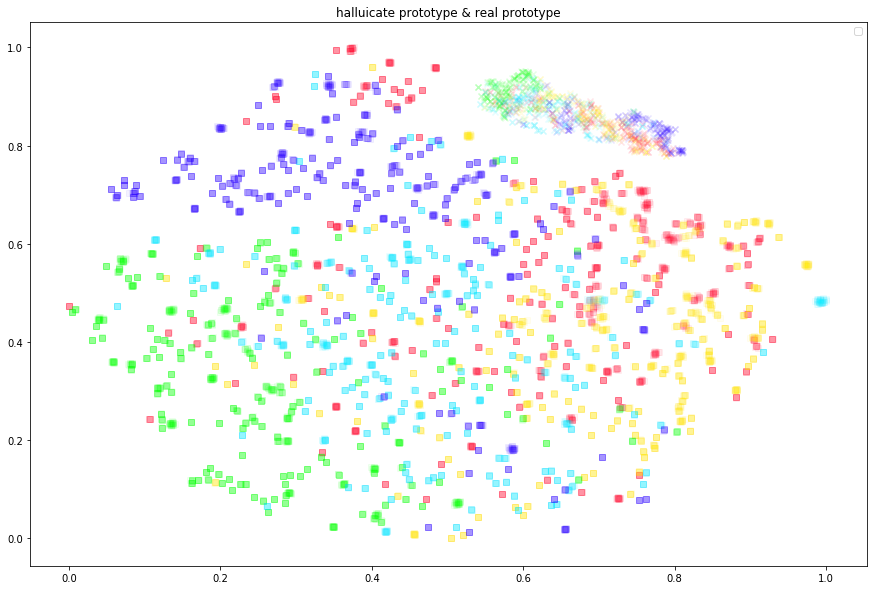

In [8]:
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/n_classes) for i in range(64)]

plt.figure(figsize=(15,10))
plt.title(f'halluicate prototype & real prototype')

for j in range(64):
    # proto
    idxs = (all_labels[:len(proto)]==j)
    plt.scatter(X_norm[:len(proto)][idxs, 0], X_norm[:len(proto)][idxs, 1], marker='x', color=colors[j], alpha=0.1)#, label=j)
    # proto hallu
    idxs = (all_labels[len(proto):]==j)
    plt.scatter(X_norm[len(proto):][idxs, 0], X_norm[len(proto):][idxs, 1], marker='s', color=colors[j], alpha=0.05)#, label=j)
plt.legend(loc='best')